In [34]:
import torch
import numpy as np
import os
from detectron2.config import get_cfg
from croptrain import add_croptrainer_config
cfg = get_cfg()
add_croptrainer_config(cfg)
cfg.merge_from_file(os.path.join(os.getcwd(), 'configs', 'Base-RCNN-FPN.yaml'))
from croptrain.data.datasets.visdrone import load_visdrone_instances
from croptrain.data.datasets import visdrone
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.file_io import PathManager
from detectron2.data.build import get_detection_dataset_dicts, build_batch_data_loader
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.samplers import TrainingSampler
from detectron2.data.common import DatasetFromList, MapDataset
from croptrain.data.dataset_mapper import DatasetMapperDensityCrop
from croptrain.data.datasets.visdrone import register_visdrone
from detectron2.data.build import get_detection_dataset_dicts
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode, Visualizer
from PIL import Image
import cv2

In [67]:
data_dir = os.path.join(os.environ['SLURM_TMPDIR'], "VisDrone")
dataset_name = 'visdrone_2019_train'
#register_visdrone(cfg.DATASETS.TRAIN[0], data_dir, cfg, True)
#dataset_dicts = visdrone.load_visdrone_instances(dataset_name, data_dir, cfg)
dataset_dicts = get_detection_dataset_dicts(cfg.DATASETS.TRAIN, filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS)
dataset = DatasetFromList(dataset_dicts, copy=False)
if cfg.CROPTRAIN.USE_CROPS:
    mapper = DatasetMapperDensityCrop(cfg, True)
if mapper is None:
    mapper = DatasetMapper(cfg, True)
dataset = MapDataset(dataset, mapper)
sampler = TrainingSampler(len(dataset))
data_loader = build_batch_data_loader(dataset, sampler, cfg.SOLVER.IMS_PER_BATCH)

Dataset with pre-computed crops loaded from /localscratch/akhil135.9968191.0/VisDrone/train_crops.pkl


In [68]:
annos = dataset_dicts[0].get("annotations", None)
print(annos)

[{'iscrowd': 0, 'bbox': [1054, 739, 1077, 763], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1236, 714, 1263, 736], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1068, 479, 1086, 507], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1073, 440, 1093, 468], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1092, 445, 1112, 469], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1114, 447, 1132, 473], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1110, 412, 1132, 436], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1055, 421, 1074, 448], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1042, 390, 1060, 414], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1222, 390, 1242, 414], 'category_id': 0, 'bbox_mode': <Bo

In [103]:
def plot_image(data_dict, meta):
    if data_dict['full_image']:
        img = np.array(Image.open(data_dict["file_name"]))
    if not data_dict['full_image']:
        img = Image.open(data_dict["file_name"])
        crop_area = data_dict['crop_area']
        x1, y1, x2, y2 = crop_area[0], crop_area[1], crop_area[2], crop_area[3]
        img = img.crop((x1, y1, x2, y2))
        min_size = min(x2-x1, y2-y1)
        new_size = (int((320/min_size)*(x2-x1)), (int(320/min_size)*(y2-y1)))
        img = img.resize(new_size)
        img = np.array(img)
    visualizer = Visualizer(img, metadata=meta)
    vis = visualizer.draw_dataset_dict(data_dict)
    #save_path = os.path.join(os.getcwd(), "temp", data_dict["file_name"].split('/')[-1])
    #vis.save(save_path)
    plt.figure(figsize=(20,10))
    plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
    #plt.imshow(vis)
    plt.show()

    
def plot_instances(data_dict, meta):
    img = np.array(Image.open(data_dict["file_name"]))
    visualizer = Visualizer(img, metadata=meta)
    vis = visualizer.draw_instance_predictions(data_dict)
    #save_path = os.path.join(os.getcwd(), "temp", data_dict["file_name"].split('/')[-1])
    #vis.save(save_path)
    plt.figure(figsize=(20,10))
    plt.imshow(vis.get_image()[..., ::-1][..., ::-1])
    #plt.imshow(vis)
    plt.show()
    

In [69]:
metadata = MetadataCatalog.get(dataset_name)
data = next(iter(data_loader))

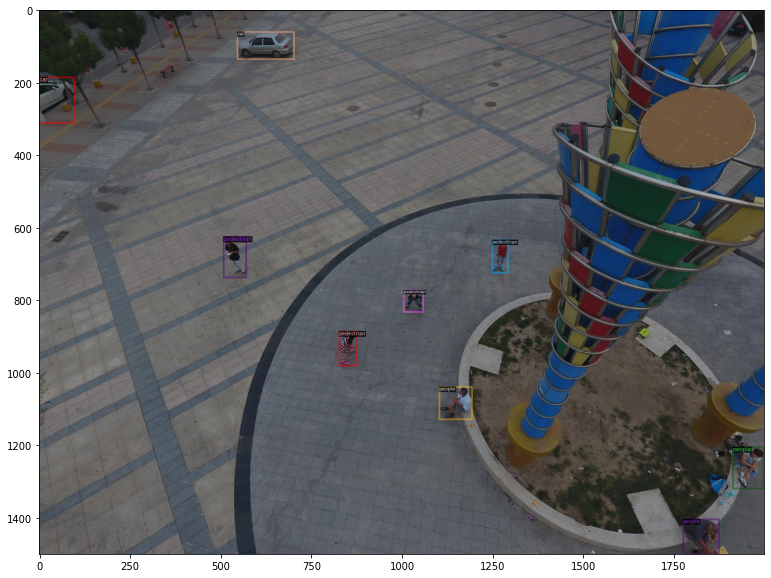

In [114]:
plot_image(dataset_dicts[250], metadata)

In [65]:
print(len(dataset))

20483


In [61]:
data_dicts = visdrone.load_visdrone_instances(dataset_name, data_dir, cfg, True)
annos = dataset_dicts[0].get("annotations", None)
print(annos)

Dataset with pre-computed crops loaded from /localscratch/akhil135.9968191.0/VisDrone/train_crops.pkl
[{'iscrowd': 0, 'bbox': [1054, 739, 1077, 763], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1236, 714, 1263, 736], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1068, 479, 1086, 507], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1073, 440, 1093, 468], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1092, 445, 1112, 469], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1114, 447, 1132, 473], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1110, 412, 1132, 436], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1055, 421, 1074, 448], 'category_id': 0, 'bbox_mode': <BoxMode.XYXY_ABS: 0>}, {'iscrowd': 0, 'bbox': [1042, 390, 1060, 414], 'category_id': 0, 'bbox_mode': <Bo